In [1]:

import os
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wave_net import WaveNet
from wave_net_utils import load_voices_files, get_max_length,fill_voices_data_with_pads, quantize_voices, get_voices_labels,load_train_data, batch_iter_to_queue
from multiprocessing import Process, Queue


In [2]:

model = WaveNet(30, layer_channels=16)
model.train()
# device = torch.device("cuda:0")
device = torch.device("cpu") 
print('use device: %s' % device, file=sys.stderr)
model = model.to(device)


use device: cpu


In [6]:


clip_size=7680
train_records = 1000
epoch_size = 64
train_batch_size = 32
max_epoch = 10

data_queue = Queue(1)
batch_queue = Queue(1)
loss_queue = Queue(2)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_data_to_queue_process = Process(target=load_train_data, args=('dataset/train', train_records, epoch_size, data_queue, clip_size,10))
train_data_to_queue_process.start()

batch_iter_to_queue_process = Process(target=batch_iter_to_queue, args=(data_queue, batch_queue, loss_queue, max_epoch, train_batch_size, True))
batch_iter_to_queue_process.start()
print("start training...")

epoch, batch_data = batch_queue.get(True)
iter = 0
while batch_data is not None :
    optimizer.zero_grad()
    # forward + backward + optimize
    labels = torch.tensor(batch_data[1:]).long().to(device)
    outputs = model(batch_data[:-1], None)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()  
    iter += 1
    batch_loss = loss.item()/len(batch_data)
    print('epoch: [%d] iter: [%d] loss: %.3f' % (epoch, iter, batch_loss))
    loss_queue.put(batch_loss, True)
    epoch, batch_data = batch_queue.get(True)

print("training end.")
train_data_to_queue_process.join()





loading train data ...
remaining train data length: 0
geting train data ...
pushing new round train data: 0
push new train data ...
start new training 1: data(size = 74) in 1000 epoches : ...
start training...
pushing new round train data: 1
push new train data ...
epoch: [0] iter: [1] loss: 1.700
epoch: [0] iter: [2] loss: 1.441
epoch: [0] iter: [3] loss: 3.873
epoch: [1] iter: [4] loss: 1.023
epoch: [1] iter: [5] loss: 0.839
epoch: [1] iter: [6] loss: 2.241
epoch: [2] iter: [7] loss: 0.598
epoch: [2] iter: [8] loss: 0.504
epoch: [2] iter: [9] loss: 1.338
epoch: [3] iter: [10] loss: 0.337
epoch: [3] iter: [11] loss: 0.266
epoch: [3] iter: [12] loss: 0.683
epoch: [4] iter: [13] loss: 0.194
epoch: [4] iter: [14] loss: 0.190
epoch: [4] iter: [15] loss: 0.620
epoch: [5] iter: [16] loss: 0.188
epoch: [5] iter: [17] loss: 0.183
epoch: [5] iter: [18] loss: 0.568
epoch: [6] iter: [19] loss: 0.178
epoch: [6] iter: [20] loss: 0.178
epoch: [6] iter: [21] loss: 0.571
epoch: [7] iter: [22] loss: 0

KeyboardInterrupt: 

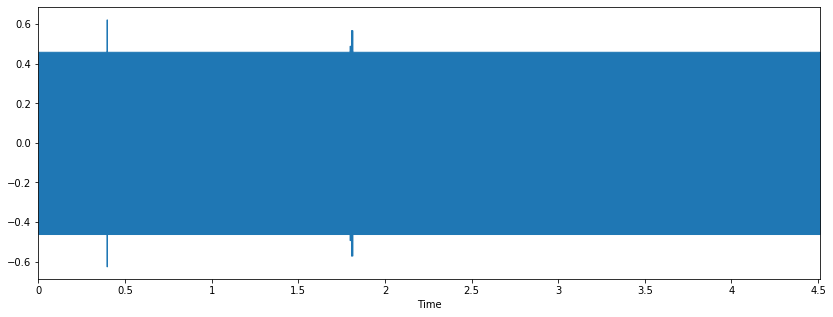

In [9]:
%matplotlib inline
# https://musicinformationretrieval.com/ipython_audio.html
# https://github.com/librosa/tutorial/blob/master/Librosa%20tutorial.ipynb

voices=load_voices_files(['dataset/train/LJ050-0274.wav'])
voices=get_voices_labels(voices)

plt.figure(figsize=(14, 5))
outputs = model(voices, None)
reconstructed_voices = model.reconstruct_from_output(outputs)
# reconstructed_voices = reconstructed_voices / (65,536/2)
x = reconstructed_voices[0] / (65536/2)
x = x.cpu().detach().numpy()
# x = np.array(voices[0]) / (65536/2)
librosa.display.waveplot(x, sr=22000)
ipd.Audio(x, rate=22000)

In [2]:
X = librosa.stft(x)
Xdb =   .amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=22000, x_axis='time', y_axis='hz')

SyntaxError: invalid syntax (<ipython-input-2-372603c2ec98>, line 2)

In [3]:
from multiprocessing import Process, Queue

voices = load_voices_files(['dataset/dev/LJ050-0274.wav'])

leading_voices = [voices[0][:1024]]
context = torch.rand(1, 1024*5, 768)
sample_queue = Queue(10)
voices = None


def generate_voices():
    with torch.no_grad():
        generated_voices = model.generate(leading_voices, context, sample_queue)

voice_generating_process = Process(target=generate_voices)
voice_generating_process.start()
while True:
    sample = sample_queue.get(True)
    if sample is None:
        print("collect done!")
        break
    print("received sample")
    if voices is None:
        voices = sample
    else:
        voices = np.concatenate((voices, sample), axis=1)

x = voices[0] / (65536/2)
librosa.display.waveplot(x, sr=22000)
ipd.Audio(x, rate=22000)

NameError: name 'load_voices_files' is not defined